## Running time evalaution

The purpose of this notebook was to identify generally how we will approach training the propensity score matching models. Using sparse matrices and the built in arithmatic functions for them we are able to acheive reasonable running times even when the matrices approach 10 million reports for 7,000 drugs and drug ingredients. See below for details.

Note that the sections below (dividing by markdown blocks) are in reverse order. 

In [22]:
import sys
import time
import timeit

import scipy as sp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [23]:
sys.path.append('../src')
from propensity_score_match import get_features, get_labels
from faers_processor import save_json, load_json, generate_file_md5, save_object, load_object

## Test using the actual data

Below we tested using simulated data. Here we load a sample of the actual data and retest running times.

In [24]:
dataset_info = load_json('../data/faers/drug/datasets/drug_2004-2004/dataset.json')

In [25]:
features = get_features(dataset_info, 
                        feature_method='droprare', 
                        dataset_path='../data/faers/drug/datasets/drug_2004-2004/',
                        droprare_min=10)
features.shape, features.getnnz(), features.getnnz()/(features.shape[0]*features.shape[1])

  Loading feature matrices from disk.
  Concatenating feature matrices into single matrix.
  Dropping columns without enough data.
    Reduced columns from 54310 to 4323, a 92.04% reduction.


((199818, 4323), 805017, 0.0009319341113945961)

In [26]:
labels, colnames = get_labels(dataset_info, 
                              dataset_path='../data/faers/drug/datasets/drug_2004-2004/',
                              exposed_min=10)
labels.shape, labels.getnnz(), labels.getnnz()/(labels.shape[0]*labels.shape[1])

  Loading labels matrix from disk.
  Removing examples with too few reports.
    Reduced columns from 5357 to 1640, a 69.39% reduction.


((199818, 1640), 414124, 0.001263723158806221)

In [28]:
aurocs = list()
xval_aurocs = list()
start = time.time()
nreports = labels.shape[0]
for i in tqdm(range(labels.shape[1]), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    
    p = max(labels[:,i].sum(), 10000)/labels.shape[0]
    mask = np.where((labels[:,i].T + np.random.binomial(1, p, nreports)) > 0)[1]
    
    intersection = (labels[mask,i].multiply(features[mask,:])).sum(axis=0)
    union = labels[mask,i].sum() + features[mask,:].sum(axis=0) - intersection
    
    tanimoto = intersection / union
    
    feature_mask = np.where(np.squeeze(np.asarray(tanimoto > 0)) & np.squeeze(np.asarray(tanimoto < 0.4)))[0]
    if len(feature_mask) == 0:
        continue
    
    i_features = features[mask,:][:,feature_mask]
    i_labels = labels[mask,i].toarray()
    
    lr = LinearRegression()
    reg = lr.fit(i_features, i_labels)
    
    auroc = roc_auc_score(i_labels, lr.predict(i_features))
    aurocs.append(auroc)
    
    # this is time consuming and only used to evaluate fit, would not be used in
    # actual model training
    # xval_aurocs.append(cross_val_score(lr, i_features, i_labels, scoring='roc_auc', cv=2).mean())
    
print(f"Completed in {time.time()-start}s")

100%|██████████| 1640/1640 [02:11<00:00, 12.47it/s]                                                                                                                                                                                                           

Completed in 131.4716727733612s


(array([   2.,    2.,    5.,    6.,   14.,   21.,   22.,   71.,  284.,
        1212.]),
 array([0.52099049, 0.56889144, 0.61679239, 0.66469334, 0.71259429,
        0.76049524, 0.80839619, 0.85629715, 0.9041981 , 0.95209905,
        1.        ]),
 <BarContainer object of 10 artists>)

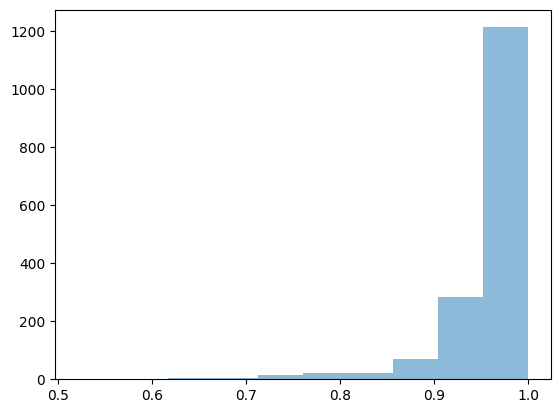

In [29]:
plt.hist(aurocs, alpha=0.5, bins=10)
# plt.hist(xval_aurocs, alpha=0.5, bins=10);

## Test out using small matrices

In [30]:
rng = np.random.default_rng()
# rvs = sp.stats.poisson(1, loc=1).rvs
rvs = sp.stats.binom(1, 0.5).rvs

In [31]:
A = sp.sparse.random(10, 4, density=1.0, random_state=rng, data_rvs=rvs).tocsc()
B = sp.sparse.random(10, 6, density=1.0, random_state=rng, data_rvs=rvs).tocsc()
# B = sp.sparse.csr_matrix(np.ones((3, 6)))

In [32]:
A[:,0].A, B.A

(array([[1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.]]),
 array([[1., 1., 0., 0., 1., 0.],
        [0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0.],
        [1., 1., 1., 1., 0., 1.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0.]]))

In [33]:
# Memory and compute efficient computation of tanimoto coefficient
i = 0

intersection = (A[:,i].multiply(B)).sum(axis=0)
union = A[:,i].sum() + B.sum(axis=0) - intersection
tanimoto = intersection / union
print(intersection)
print(union)
print(tanimoto)
A[:,i].A

[[4. 3. 2. 2. 2. 2.]]
[[7. 7. 7. 8. 8. 7.]]
[[0.57142857 0.42857143 0.28571429 0.25       0.25       0.28571429]]


array([[1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.]])

In [34]:
%timeit np.random.binomial(1, 0.01, 1000000)
%timeit [np.random.binomial(1, 0.01) for _ in range(1000000)]

9.51 ms ± 627 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
644 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Test out with large random data

In [35]:
# simulating the amount of data and density we have 
# in the real matrices, which is approx: 
# 10 million by 5,000 for the features and
# 10 million by 2,000 for the labels

rvs = sp.stats.binom(1, 1.0).rvs
nreports= 1_000_000
A = sp.sparse.random(nreports, 5_000, density=0.0002, random_state=rng, data_rvs=rvs).tocsc()
# B = sp.sparse.random(nreports, 100, density=0.0002, random_state=rng, data_rvs=rvs).tocsc()
B = sp.sparse.hstack([A, sp.sparse.random(nreports, 2_000, density=0.0002, random_state=rng, data_rvs=rvs).tocsc()])

print(A.shape, A.sum()/(A.shape[0]*A.shape[1]))
print(B.shape, B.sum()/(B.shape[0]*B.shape[1]))

# tanimoto = np.zeros((A.shape[1], B.shape[1]))
aurocs = list()
xval_aurocs = list()
start = time.time()
for i in tqdm(range(A.shape[1]), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    
    p = max(A[:,i].sum(), 10000)/A.shape[0]
    mask = np.where((A[:,i].T + np.random.binomial(1, 0.01, nreports)) > 0)[1]
    
    intersection = (A[mask,i].multiply(B[mask,:])).sum(axis=0)
    union = A[mask,i].sum() + B[mask,:].sum(axis=0) - intersection
    
    tanimoto = intersection / union
    
    feature_mask = np.where(np.squeeze(np.asarray(tanimoto > 0)) & np.squeeze(np.asarray(tanimoto < 0.2)))[0]
    features = B[mask,:][:,feature_mask]
    labels = A[mask,i].toarray()
    
#     print(features.shape, labels.shape)
    lr = LinearRegression()
    reg = lr.fit(features, labels)
#     predictions = (B[:,feature_mask] @ reg.coef_.T)
    
    auroc = roc_auc_score(labels, lr.predict(features))
    aurocs.append(auroc)
    
    # this is time consuming and only used to evaluate fit, would not be used in
    # actual model training
    # xval_aurocs.append(cross_val_score(lr, features, labels, scoring='roc_auc').mean())
#     print(reg.coef_.shape)
#     print(reg.intercept_)
#     result = sp.sparse.linalg.lsqr(features, labels)
#     x = result[0]
#     prediction = features @ x
#     error = prediction-labels.ravel()
#     print(np.abs(error).mean())
#     print(prediction.sum())
#     print(labels.sum())
#     break
    
print(f"Completed in {time.time()-start}s")

(1000000, 5000) 0.0002
(1000000, 7000) 0.0002


100%|██████████| 5000/5000 [04:51<00:00, 17.14it/s]                                                                                                                                                                                                           

Completed in 291.7316610813141s


In [36]:
lr = LinearRegression()
cross_val_score(lr, features, labels, scoring='roc_auc').mean()

0.18935714841560403

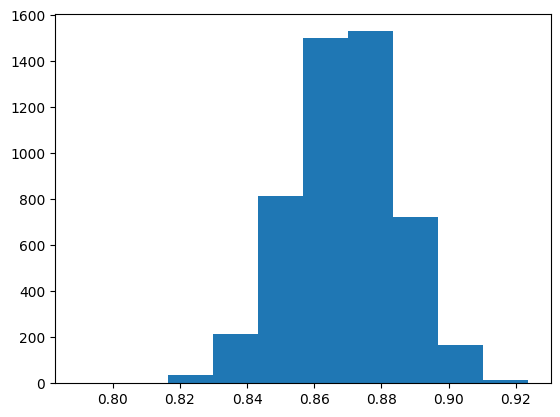

In [37]:
plt.hist(aurocs);

(1000000, 298) (1, 298)
<class 'numpy.ndarray'> (1000000, 1)


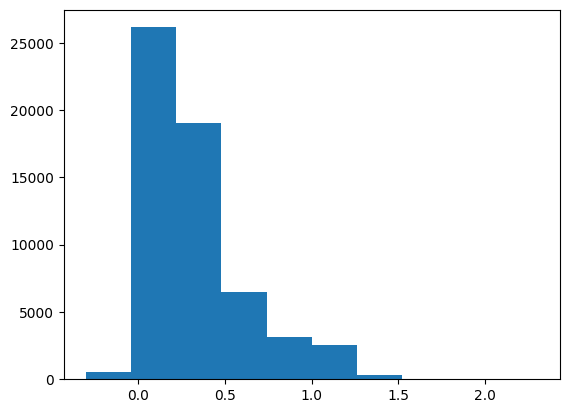

In [38]:
print(B[:,feature_mask].shape, reg.coef_.shape)
predictions = (B[:,feature_mask] @ reg.coef_.T)
print(type(predictions), predictions.shape)
plt.hist(predictions[predictions!=0]);

## Compare performance of CSC matrix to CSR matrix for Tanimoto calculation

This test is peformed on the entire matrix to increase computational load. In actual method we will restrict to a sample of the unexposed reports (above). 

Results: CSC is faster.

In [161]:
rvs = sp.stats.binom(1, 1.0).rvs
A = sp.sparse.random(1000000, 1000, density=0.0002, random_state=rng, data_rvs=rvs).tocsc()
B = sp.sparse.random(1000000, 100, density=0.0002, random_state=rng, data_rvs=rvs).tocsc()
print(A.sum()/(A.shape[0]*A.shape[1]))
print(B.sum()/(B.shape[0]*B.shape[1]))

start = time.time()
for i in tqdm(range(A.shape[1]), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    intersection = (A[:,i].multiply(B)).sum(axis=0)
    union = A[:,i].sum() + B.sum(axis=0) - intersection
    tanimoto = intersection / union
    #print(tanimoto)
print(f"Completed in {time.time()-start}s")

0.0002
0.0002


100%|██████████| 1000/1000 [00:25<00:00, 39.44it/s]                                                                                                                                                                                                           

Completed in 25.35836696624756s


In [162]:
A = A.tocsr()
B = B.tocsr()
print(A.sum()/(A.shape[0]*A.shape[1]))
print(B.sum()/(B.shape[0]*B.shape[1]))

start = time.time()
for i in tqdm(range(A.shape[1]), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    intersection = (A[:,i].multiply(B)).sum(axis=0)
    union = A[:,i].sum() + B.sum(axis=0) - intersection
    tanimoto = intersection / union
    #print(tanimoto)
print(f"Completed in {time.time()-start}s")

0.0002
0.0002


100%|██████████| 1000/1000 [00:40<00:00, 24.68it/s]                                                                                                                                                                                                           

Completed in 40.52141809463501s
